<a href="https://colab.research.google.com/github/dtminnick/pytorch-practice/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Convert mnist image files into tensor of four dimensions
# Number of images, height, width, color channel
transform = transforms.ToTensor()

In [ ]:
# Train data
train_data = datasets.MNIST(root = '/cnn_data',
                            train = True,
                            download = True,
                            transform = transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.76MB/s]


In [ ]:
# Test data
test_data = datasets.MNIST(root = '/cnn_data',
                            train = False,
                            download = True,
                            transform = transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
pwd

'/content'

In [ ]:
# Create small batch size for images, 10
train_loader = DataLoader(train_data,
                          batch_size = 10,
                          shuffle = True)



In [ ]:
# Create small batch size for images, 10
test_loader = DataLoader(test_data,
                          batch_size = 10,
                          shuffle = False)

In [ ]:
# Define CNN model
# Describe convolutional layer and what its doing (2 layers)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [ ]:
# Grab 1 Mnist record
for i, (X_train, y_train) in enumerate(train_data):
  break

In [ ]:
X_train.shape

torch.Size([1, 28, 28])

In [ ]:
x = X_train.view(1, 1, 28, 28)

In [ ]:
# Preform out first convolution
x = f.relu(conv1(x))

In [ ]:
# 1 single images
# 6 filters we asked for
# 26 reduced because did not set padding

x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
# pass through the pooling layer
x = f.max_pool2d(x, 2, 2) # kernel size 2, stride size 2

In [ ]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [ ]:
# Second convolutional layer
x = f.relu(conv2(x))

In [ ]:
x.shape # didn't set padding so lose two pixels around outside

torch.Size([1, 16, 11, 11])

In [ ]:
# Pooling layer
x = f.max_pool2d(x, 2, 2)

In [ ]:
x.shape # 11 /2 5 round down

torch.Size([1, 16, 5, 5])

In [ ]:
# Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def  forward(self, X):
    X = f.relu(self.conv1(X))
    X = f.max_pool2d(X, 2, 2) # 2 by 2 kernel and stride of 2
    # second pass
    X = f.relu(self.conv2(X))
    X = f.max_pool2d(X, 2, 2)

    # Review data to flatten it
    X = X.view(-1, 16*5*5) # Negative 1 so that we can vary the batch size

    # Need out fully connected layers
    X = f.relu(self.fc1(X))
    X = f.relu(self.fc2(X))
    X = self.fc3(X)
    return f.log_softmax(X, dim = 1)

In [ ]:
# Create instance of model and set manual seed
torch.manual_seed(41)

model = ConvolutionalNetwork()

model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# Smaller the lr, the longer it takes to train

In [ ]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 600  Loss: 0.1623610556125641
Epoch: 0  Batch: 1200  Loss: 0.1502392590045929
Epoch: 0  Batch: 1800  Loss: 0.4744560718536377
Epoch: 0  Batch: 2400  Loss: 0.14238706231117249
Epoch: 0  Batch: 3000  Loss: 0.007758188061416149
Epoch: 0  Batch: 3600  Loss: 0.3836284875869751
Epoch: 0  Batch: 4200  Loss: 0.0038223876617848873
Epoch: 0  Batch: 4800  Loss: 0.0021286322735249996
Epoch: 0  Batch: 5400  Loss: 0.0569545142352581
Epoch: 0  Batch: 6000  Loss: 0.00038789428072050214
Epoch: 1  Batch: 600  Loss: 0.005851339548826218
Epoch: 1  Batch: 1200  Loss: 0.3855525553226471
Epoch: 1  Batch: 1800  Loss: 0.004819948226213455
Epoch: 1  Batch: 2400  Loss: 0.003216963727027178
Epoch: 1  Batch: 3000  Loss: 0.0332382395863533
Epoch: 1  Batch: 3600  Loss: 0.5372857451438904
Epoch: 1  Batch: 4200  Loss: 0.04561494290828705
Epoch: 1  Batch: 4800  Loss: 0.0007510822033509612
Epoch: 1  Batch: 5400  Loss: 0.0001173773780465126
Epoch: 1  Batch: 6000  Loss: 0.14201366901397705
Epoch: 2  Batch

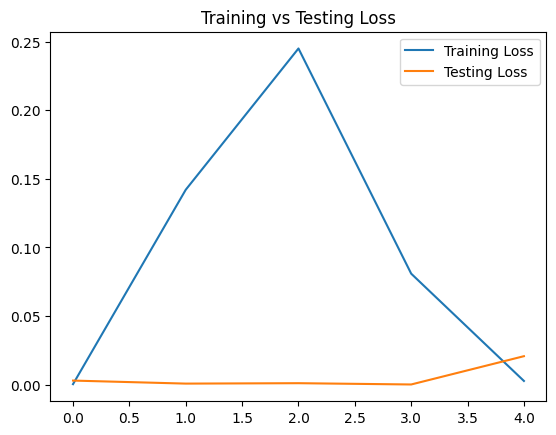

In [ ]:
# Graph the loss at each epoch
train_losses = [t.item() for t in train_losses]
test_losses = [t.item() for t in test_losses]
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Testing Loss')
plt.title('Training vs Testing Loss')
plt.legend()

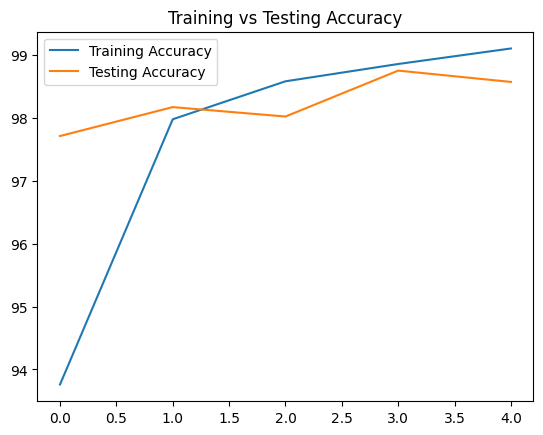

In [ ]:
# Graph accuracy and end of each epoch
plt.plot([t/600 for t in train_correct], label = 'Training Accuracy')
plt.plot([t/100 for t in test_correct], label = 'Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()

In [ ]:
test_load_everything = DataLoader(test_data,
                                  batch_size = 10000,
                                  shuffle = False)

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test Accuracy: {correct/10000}')

Test Accuracy: 0.9857000112533569


In [ ]:
correct.item()/len(test_data) * 100

98.57000000000001

In [37]:
# Grab an image
test_data[4143] # A tensor with an image in it...at end it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [38]:
# Grab the data
test_data[4143][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

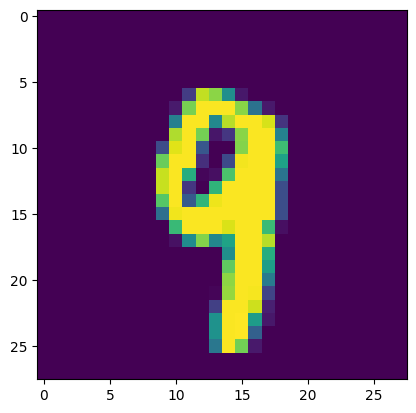

In [39]:
# Show the image
plt.imshow(test_data[4143][0].reshape(28, 28))

In [40]:
# Pass image through model
model.eval()
with torch.no_grad():
  new_predict = model(test_data[4143][0].view(1, 1, 28, 28))
  # Batch size of 1, 1 color channel, 28x28 image

In [42]:
# Check new prediction...get probability
new_predict

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [43]:
new_predict.argmax()

tensor(9)